In [61]:
#导入相关库
import numpy as np
import scipy.sparse
# import cPickle
import xgboost as xgb
import warnings
warnings='ignore'

dtrain=xgb.DMatrix('agaricus.txt.train')
dtest=xgb.DMatrix('agaricus.txt.test')

[11:06:06] 6513x127 matrix with 143286 entries loaded from agaricus.txt.train
[11:06:06] 1611x127 matrix with 35442 entries loaded from agaricus.txt.test


In [62]:
#简单训练xgb
param={'max_depth':2,'eta':1,'silent':1,'objective':'binary:logistic'}  
#max_depth设置树的最大深度,defult=6;eta可以视作学习率,defult=0.3,取值范围[0,1];objective损失函数，binary:logistic是二分类的逻辑回归，defult=reg:linear线性回归
watch_list = [(dtest,'eval'),(dtrain,'train')]  #也叫eval_list()可以对比训练集和测试集上的评价指标的变化
num_round = 10
model = xgb.train(param,dtrain,num_round,watch_list)

[0]	eval-error:0.042831	train-error:0.046522
[1]	eval-error:0.021726	train-error:0.022263
[2]	eval-error:0.006207	train-error:0.007063
[3]	eval-error:0.018001	train-error:0.0152
[4]	eval-error:0.006207	train-error:0.007063
[5]	eval-error:0	train-error:0.001228
[6]	eval-error:0	train-error:0.001228
[7]	eval-error:0	train-error:0.001228
[8]	eval-error:0	train-error:0.001228
[9]	eval-error:0	train-error:0


In [63]:
#预测
pred = model.predict(dtest)
labels = dtest.get_label()
error_num = sum([index for index in range(len(pred)) if int(pred[index]>0.5)!=labels[index]])
error_num

0

In [64]:
#存储模型
model.dump_model('1.model')

In [65]:
#kfold交叉验证
import numpy as np
import xgboost as xgb
dtrain = xgb.DMatrix('agaricus.txt.train')
param = {'max_depth':2,'eta':1,'silent':1,'objective':'binary:logistic'}  #silent表示是否在构造过程中打印消息
num_round = 5
xgb.cv(param,dtrain,num_round,nfold=5,metrics={'error'},seed=1128)

[11:06:06] 6513x127 matrix with 143286 entries loaded from agaricus.txt.train


,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.046522,0.001452,0.046524,0.005809
1,0.022263,0.000933,0.022264,0.003733
2,0.007063,0.000255,0.007063,0.001020
3,0.015200,0.000562,0.015201,0.002246
4,0.007063,0.000255,0.007063,0.001020


In [66]:
#预处理样本权重
def preproc(dtrain,dtest,param):
    labels=dtrain.get_label()
    ratio=float(np.sum(labels==0))/np.sum(labels==1)
    param['scale_pos_weight']=ratio  #scale_pos_weight是一个样本权重的参数
    return dtrain,dtest,param 

xgb.cv(param,dtrain,num_round,nfold=5,metrics={'auc'},seed=1128,fpreproc=preproc)

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.958226,0.001365,0.958203,0.005445
1,0.981412,0.000611,0.981395,0.002421
2,0.997069,0.000277,0.997048,0.001102
3,0.998669,0.000194,0.998531,0.000497
4,0.998857,0.000418,0.998367,0.001298


In [69]:
#自定义目标函数（损失函数）与交叉验证
def logregobj(pred,dtrain):  #log似然函数
    labels=dtrain.get_label()
    pred=1.0/(1+np.exp(-pred)) #预测的y值
    grad=pred-labels   #log函数一阶导数
    hess=pred*(1-pred) #二阶导数，具体求导过程可以看：https://blog.csdn.net/qq_36231549/article/details/81411932
    return grad,hess

def evalerror(pred,dtrain):
    labels=dtrain.get_label()
    return 'error',float(sum(labels!=(pred>0.0)))/len(labels)

param = {'max_depth':2,'eta':1,'silent':1} #silent:0表示输出信息， 1表示安静模式
model = xgb.train(param,dtrain,num_round,watch_list,logregobj,evalerror)

[0]	eval-rmse:1.59229	train-rmse:1.59597	eval-error:0.042831	train-error:0.046522
[1]	eval-rmse:2.40519	train-rmse:2.40977	eval-error:0.021726	train-error:0.022263
[2]	eval-rmse:2.88253	train-rmse:2.87459	eval-error:0.006207	train-error:0.007063
[3]	eval-rmse:3.62808	train-rmse:3.63621	eval-error:0.018001	train-error:0.0152
[4]	eval-rmse:3.80794	train-rmse:3.83893	eval-error:0.006207	train-error:0.007063


In [74]:
#5折交叉验证
xgb.cv(param,dtrain,num_round,nfold=5,seed=1128,obj=logregobj,feval=evalerror) #显示自定义的损失函数和评价指标

,train-error-mean,train-error-std,train-rmse-mean,train-rmse-std,test-error-mean,test-error-std,test-rmse-mean,test-rmse-std
0,0.046522,0.001452,1.594731,0.003350,0.046524,0.005809,1.594990,0.008446
1,0.022263,0.000933,2.403637,0.007729,0.022264,0.003733,2.403963,0.015202
2,0.007063,0.000255,2.856347,0.010825,0.007063,0.001020,2.856422,0.011791
3,0.015200,0.000562,3.619278,0.006915,0.015201,0.002246,3.619003,0.019334
4,0.004530,0.002917,3.867662,0.106169,0.005527,0.002677,3.866511,0.120997


In [75]:
#用一颗树做预测
pred1=model.predict(dtest,ntree_limit=1)
print(evalerror(pred1,dtest))

('error', 0.04283054003724395)


In [76]:
#用两颗树做预测
pred2=model.predict(dtest,ntree_limit=2)
print(evalerror(pred2,dtest))

('error', 0.021725636250775917)


In [77]:
#用三颗树做预测
pred3=model.predict(dtest,ntree_limit=3)
print(evalerror(pred3,dtest))

('error', 0.006207324643078833)


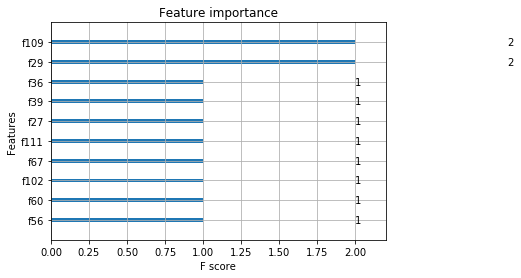

In [79]:
#画出特征重要度
%matplotlib inline
from xgboost import plot_importance
import matplotlib.pyplot as plt
plot_importance(model,max_num_features=10)
plt.show()

In [81]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import KFold,train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix,mean_squared_error  
from sklearn.datasets import load_iris,load_digits,load_boston 

In [95]:
#用xgboost建模，sklearn评估
#二分类问题用混淆矩阵评估
digits = load_digits()
y=digits['target']
x=digits['data']
print(x.shape,y.shape)
print("")
#k折切分
kf = KFold(n_splits=2,shuffle=True,random_state=1128)
for train_index,test_index in kf.split(x):  #kf.split返回切分数据的索引
    xgboost_model = xgb.XGBClassifier().fit(x[train_index],y[train_index])
    pred = xgboost_model.predict(x[test_index])
    ground_truth = y[test_index]
    print(confusion_matrix(ground_truth,pred)) #混淆矩阵参考链接：https://blog.csdn.net/Orange_Spotty_Cat/article/details/80520839

(1797, 64) (1797,)

[[ 87   0   0   0   0   2   0   0   1   0]
 [  0  84   2   0   0   0   1   0   0   1]
 [  0   1  81   4   0   0   0   0   1   1]
 [  0   0   0  90   0   1   0   2   4   1]
 [  0   2   0   0  80   0   1   0   2   0]
 [  0   1   0   0   0  74   0   0   1   2]
 [  0   0   1   0   0   1 102   0   2   0]
 [  0   0   0   0   0   0   0  93   2   1]
 [  0   3   0   1   0   0   0   2  76   1]
 [  0   1   0   0   0   1   0   0   2  83]]
[[88  0  0  0  0  0  0  0  0  0]
 [ 0 86  1  1  0  0  0  0  1  5]
 [ 1  1 86  0  0  0  1  0  0  0]
 [ 0  0  2 81  0  1  0  0  0  1]
 [ 0  0  0  0 93  0  0  1  2  0]
 [ 0  0  0  0  1 96  1  0  0  6]
 [ 0  0  0  0  1  0 72  0  2  0]
 [ 0  0  0  1  0  1  0 80  0  1]
 [ 0  3  1  0  0  1  0  0 86  0]
 [ 1  0  0  2  0  0  0  4  5 81]]


In [96]:
#多分类
iris = load_iris()
y_iris = iris['target']
x_iris = iris['data']
kf = KFold(n_splits=2,shuffle=True,random_state=1128)
for train_index,test_index in kf.split(x_iris):
    xgboost_model = xgb.XGBClassifier().fit(x_iris[train_index],y_iris[train_index])
    pred = xgboost_model.predict(x_iris[test_index])
    ground_truth = y_iris[test_index]
    print(confusion_matrix(ground_truth,pred))

[[29  0  0]
 [ 0 23  3]
 [ 0  0 20]]
[[21  0  0]
 [ 0 24  0]
 [ 0  2 28]]


In [99]:
#回归问题
boston = load_boston()
x_boston = boston['data']
y_boston = boston['target']
xgb_model = xgb.XGBRegressor()
param_dict = {'max_depth':[2,4,6],'n_estimator':[50,100,200]}
rgs = GridSearchCV(xgb_model,param_dict)
rgs.fit(x_boston,y_boston)
print(rgs.best_estimator_)  #最好的模型参数
print(rgs.best_score_)  #最高得分

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimator=50,
       n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)
0.6001029721598573


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
